Epoch 1/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.7795 - loss: 0.6539 - val_accuracy: 0.9250 - val_loss: 0.4124
Epoch 2/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9464 - loss: 0.3057 - val_accuracy: 0.9250 - val_loss: 0.2894
Epoch 3/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.9432 - loss: 0.2444 - val_accuracy: 0.9250 - val_loss: 0.2766
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Accuracy: 0.9250
Precision: 0.9250
Recall: 1.0000
F1 Score: 0.9610
Confusion Matrix:
[[  0  15]
 [  0 185]]


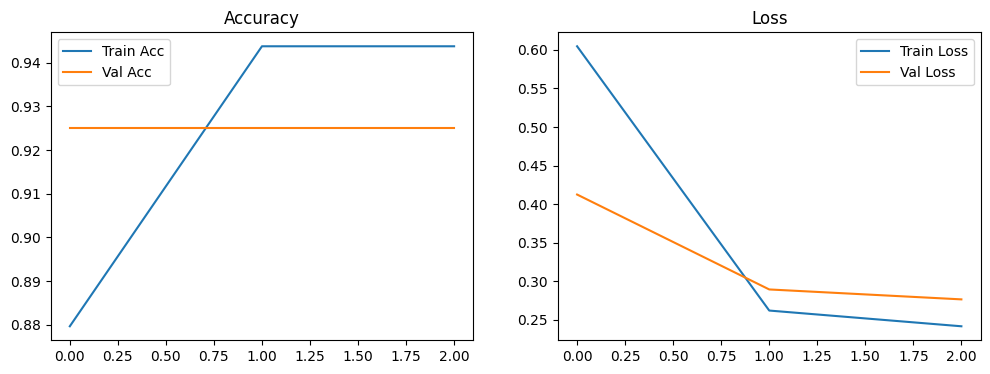

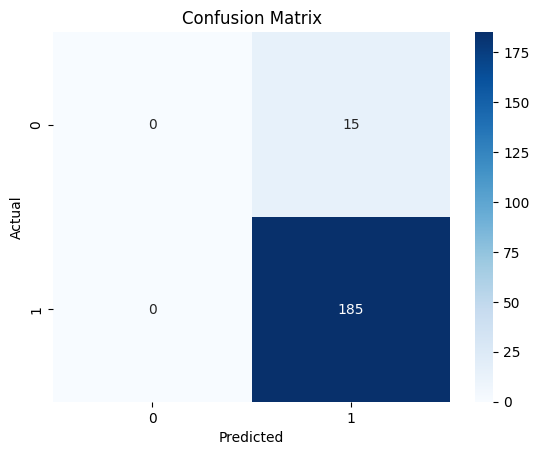

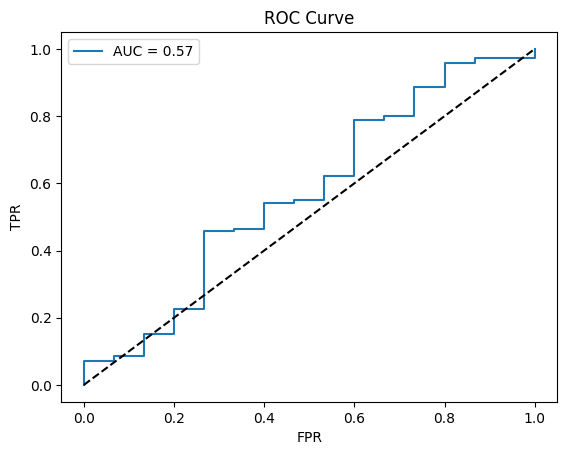


Sample Predictions
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Review:
I would recommend this to all of our friends and family. It's worth every penny. Good warranty, comes with a free subscription, works quickly and is very durable!
Predicted Sentiment: Positive (Score: 0.96)
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Review:
We bought two of these for the kids. They love them and I now have an echo dot
Predicted Sentiment: Positive (Score: 0.96)
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Review:
Not sure will be keeping this. Worried about hacks that allow active mic.
Predicted Sentiment: Positive (Score: 0.96)
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Review:
The echo show feels useless after a few hours, especially without the ability to watch YouTube.
Predicted Sentiment: Positive (Score: 0.96)
----------------------------------------
1/1

In [9]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

stop_words = set("""
a about above after again against all am an and any are aren't as at be because been before being below between both but by 
could couldn't did didn't do does doesn't doing don't down during each few for from further had hadn't has hasn't have haven't 
having he he'd he'll he's her here here's hers herself him himself his how how's i i'd i'll i'm i've if in into is isn't it 
it's its itself let's me more most mustn't my myself no nor not of off on once only or other ought our ours ourselves out over 
own same shan't she she'd she'll she's should shouldn't so some such than that that's the their theirs them themselves then 
there there's these they they'd they'll they're they've this those through to too under until up very was wasn't we we'd we'll 
we're we've were weren't what what's when when's where where's which while who who's whom why why's with won't would wouldn't 
you you'd you'll you're you've your yours yourself yourselves
""".split())

# Load data
df = pd.read_csv('/kaggle/input/consumer-reviews-of-amazon-products/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv')
df = df.dropna(subset=['reviews.text', 'reviews.rating'])
df = df.sample(1000, random_state=42)

# Text cleaning function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['cleaned_text'] = df['reviews.text'].apply(clean_text)
df['sentiment'] = df['reviews.rating'].apply(lambda x: 1 if x >= 4 else 0)

# Tokenization
max_words = 10000
max_length = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])
X = pad_sequences(sequences, maxlen=max_length)
y = df['sentiment'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM Model architecture
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=100))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model training
history = model.fit(X_train, y_train, epochs=3, batch_size=64, validation_split=0.2)

# Model evaluation
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32")

# Print evaluation metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}")

# Visualize metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

# Sample Predictions
print("\nSample Predictions\n" + "-"*40)

positive_samples = df[df['sentiment'] == 1].sample(2, random_state=1)['reviews.text'].tolist()
negative_samples = df[df['sentiment'] == 0].sample(2, random_state=2)['reviews.text'].tolist()
random_sample = df['reviews.text'].sample(1, random_state=3).tolist()
sample_texts = positive_samples + negative_samples + random_sample

for text in sample_texts:
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=max_length)
    pred_prob = model.predict(padded)[0][0]
    sentiment = "Positive" if pred_prob > 0.5 else "Negative"
    print(f"Review:\n{text.strip()[:300]}")
    print(f"Predicted Sentiment: {sentiment} (Score: {pred_prob:.2f})")
    print("-" * 40)
